In [716]:
import pandas as pd
import numpy as np
import csv as csv
%matplotlib inline
import matplotlib.pyplot as plt
import numpy
import re

from sklearn.metrics import matthews_corrcoef
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix

In [717]:
#read data
train = pd.read_csv('train.csv', header=0)
test  = pd.read_csv('test.csv',  header=0)

train['train'] = 1
test['train'] = 0

#merge both data (train and test)
data = pd.concat([train,test], join='outer', ignore_index=True)
data

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,train
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,1
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,1
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,1
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,1
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,1
5,NaN,NaN,Q,8.4583,"Moran, Mr. James",0,6,3,male,0,0.0,330877,1
6,54.0,E46,S,51.8625,"McCarthy, Mr. Timothy J",0,7,1,male,0,0.0,17463,1
7,2.0,NaN,S,21.0750,"Palsson, Master. Gosta Leonard",1,8,3,male,3,0.0,349909,1
8,27.0,NaN,S,11.1333,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,9,3,female,0,1.0,347742,1
9,14.0,NaN,C,30.0708,"Nasser, Mrs. Nicholas (Adele Achem)",0,10,2,female,1,1.0,237736,1


In [718]:
data.describe()

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived,train
count,1046.000000,1308.000000,1309.000000,1309.000000,1309.000000,1309.000000,891.000000,1309.000000
mean,29.881138,33.295479,0.385027,655.000000,2.294882,0.498854,0.383838,0.680672
std,14.413493,51.758668,0.865560,378.020061,0.837836,1.041658,0.486592,0.466394
min,0.170000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,21.000000,7.895800,0.000000,328.000000,2.000000,0.000000,0.000000,0.000000
50%,28.000000,14.454200,0.000000,655.000000,3.000000,0.000000,0.000000,1.000000
75%,39.000000,31.275000,0.000000,982.000000,3.000000,1.000000,1.000000,1.000000
max,80.000000,512.329200,9.000000,1309.000000,3.000000,8.000000,1.000000,1.000000


In [719]:
#Create a variable that describe passenger Title
data['Title'] = ''
for i in range(0,data.shape[0]):
    data.loc[i,'Title'] = re.search('\w*\.',data.Name[i]).group(0).replace('.','')
data.Title.value_counts()

Mr          757
Miss        260
Mrs         197
Master       61
Dr            8
Rev           8
Col           4
Major         2
Mlle          2
Ms            2
Don           1
Capt          1
Lady          1
Sir           1
Countess      1
Jonkheer      1
Dona          1
Mme           1
Name: Title, dtype: int64

In [720]:
#convert all rare title to 'Rare_Title' category
rare_title = ['Dr', 'Rev', 'Col', 'Major', 'Don', 'Capt', 'Lady', 'Sir', 'Countess', 'Jonkheer', 'Dona']
for i in range(0,data.shape[0]):
    data.loc[i,'Title'] = re.search('\w*\.',data.Name[i]).group(0).replace('.','')
    if(data.loc[i,'Title'] in rare_title):
        data.loc[i,'Title'] = 'Rare_Title'

#convert french miss to english
data.ix[data.Title == 'Mlle', 'Title'] = 'Miss'
data.ix[data.Title == 'Ms',   'Title'] = 'Miss'
data.ix[data.Title == 'Mme',  'Title'] = 'Miss'

data.Title.value_counts()

Mr            757
Miss          265
Mrs           197
Master         61
Rare_Title     29
Name: Title, dtype: int64

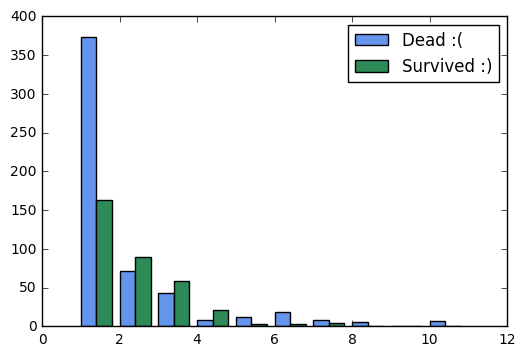

In [721]:
#create passenger family size plus him self
data['Family_size'] = data.SibSp + data.Parch + 1

a_heights, a_bins = np.histogram(data.ix[data.Survived == 0, 'Family_size'])
b_heights, b_bins = np.histogram(data.ix[data.Survived == 1, 'Family_size'], bins=a_bins)
width = (a_bins[1] - a_bins[0])/2.5
plt.bar(a_bins[:-1]        , a_heights, width=width, label='Dead :(', facecolor='cornflowerblue')
plt.bar(b_bins[:-1] + width, b_heights, width=width, label='Survived :)'    , facecolor='seagreen')
plt.legend(loc='upper right')
plt.show()

In [722]:
data['Family_size_Disc'] = ''
data.ix[data.Family_size <= 1, 'Family_size_Disc'] = 'singleton'
data.ix[(data.Family_size > 1) & (data.Family_size < 5), 'Family_size_Disc'] = 'small'
data.ix[data.Family_size >= 5, 'Family_size_Disc'] = 'large'

In [723]:
#Tratamento Cabine

In [726]:
# female = 0, Male = 1
data['Gender'] = data['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
# All missing Embarked -> just make them embark from most common place
data.loc[data.Embarked.isnull(), 'Embarked'] = data.Embarked.dropna().mode().values
# All the ages with no data -> make the mode of all Ages and create Dummy to mark NaN
data['AgeDummy'] = 0 
data.loc[data.Age.isnull(), 'AgeDummy'] = 1
data.loc[data.Age.isnull(), 'Age'] = data.Age.dropna().median()
# All missing Embarked -> just make them embark from most common place
data['Embarked_map'] = data['Embarked'].map( {'C': 0, 'Q': 1, 'S' : 2} ).astype(int)
# Remove the Name column, Cabin, Ticket, and Sex (since I copied and filled it to Gender)
f_data = data.drop(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], axis=1) 

In [727]:
f_data

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived,train,Title,Family_size,Family_size_Disc,Gender,AgeDummy,Embarked_map
0,22.0,7.2500,0,1,3,1,0.0,1,Mr,2,small,1,0,2
1,38.0,71.2833,0,2,1,1,1.0,1,Mrs,2,small,0,0,0
2,26.0,7.9250,0,3,3,0,1.0,1,Miss,1,singleton,0,0,2
3,35.0,53.1000,0,4,1,1,1.0,1,Mrs,2,small,0,0,2
4,35.0,8.0500,0,5,3,0,0.0,1,Mr,1,singleton,1,0,2
5,28.0,8.4583,0,6,3,0,0.0,1,Mr,1,singleton,1,0,1
6,54.0,51.8625,0,7,1,0,0.0,1,Mr,1,singleton,1,0,2
7,2.0,21.0750,1,8,3,3,0.0,1,Master,5,large,1,0,2
8,27.0,11.1333,2,9,3,0,1.0,1,Mrs,3,small,0,0,2
9,14.0,30.0708,0,10,2,1,1.0,1,Mrs,2,small,0,0,0


In [706]:
t_data = f_data.ix[f_data.train == 1].drop('train', axis=1)
u_data = f_data.ix[f_data.train == 0].drop('train', axis=1)
t_data

,Age,Embarked,Fare,Parch,PassengerId,Pclass,SibSp,Survived,Title,Family_size,Family_size_Disc,Gender,AgeDummy
0,22.0,2,7.2500,0,1,3,1,0.0,Mr,2,small,1,0
1,38.0,0,71.2833,0,2,1,1,1.0,Mrs,2,small,0,0
2,26.0,2,7.9250,0,3,3,0,1.0,Miss,1,singleton,0,0
3,35.0,2,53.1000,0,4,1,1,1.0,Mrs,2,small,0,0
4,35.0,2,8.0500,0,5,3,0,0.0,Mr,1,singleton,1,0
5,28.0,1,8.4583,0,6,3,0,0.0,Mr,1,singleton,1,1
6,54.0,2,51.8625,0,7,1,0,0.0,Mr,1,singleton,1,0
7,2.0,2,21.0750,1,8,3,3,0.0,Master,5,large,1,0
8,27.0,2,11.1333,2,9,3,0,1.0,Mrs,3,small,0,0
9,14.0,0,30.0708,0,10,2,1,1.0,Mrs,2,small,0,0


In [714]:
X = t_data.ix[:,['Age','Embarked','Fare','Parch','Pclass','SibSp','Title','Family_size','Family_size_Disc','Gender','AgeDummy']]
y = t_data.ix[:,'Survived']

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=.2, random_state=7)

for i in range(1, 50):
    model = RandomForestClassifier(n_estimators=100, min_samples_split=i).fit(X_train, y_train)
    pred  = model.predict(X_test)
    print str(i) + " - " + str(matthews_corrcoef(y_test, pred))

ValueError: could not convert string to float: small

In [705]:
#return (data)

#data Eng.
#def dataEng(data):
#    return (data[data.Pclass == 1], data[data.Pclass == 2], data[data.Pclass == 3])

#run data Prep and Eng
#data = dataPrep(data)
#data1, data2, data3 = dataEng(data)

In [295]:
cnf_matrix

array([[ 76,   4],
       [  5, 131]])

In [277]:
X = data3.ix[:,2:]
y = data3.ix[:,1]
print X.shape
clf = ExtraTreesClassifier()
clf = clf.fit(X, y)
print clf.feature_importances_
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X)
print X_new.shape 

(491, 8)
[ 0.          0.2963332   0.05895588  0.05719264  0.32494522  0.06588679
  0.17679876  0.01988751]
(491, 3)


In [267]:
rf = RandomForestClassifier(n_estimators=100, criterion='gini', min_samples_split=2)
X = X_new
y = data3.ix[:,1]
scores = cross_val_score(rf, X, y, cv=5, n_jobs=-1)

In [268]:
scores

array([ 0.78787879,  0.80808081,  0.78571429,  0.78571429,  0.80412371])

In [270]:
scores

array([ 0.78787879,  0.80808081,  0.78571429,  0.78571429,  0.80412371])

In [271]:
fp = open("titanicResult.csv", "wb")
fo = csv.writer(fp)
fo.writerow(["PassengerId","Survived"])
fo.writerows(zip(ids, output))
fp.close()

array([[ 22.   ,   7.25 ,   1.   ],
       [ 26.   ,   7.925,   0.   ],
       [ 35.   ,   8.05 ,   1.   ],
       ..., 
       [ 39.   ,  29.125,   0.   ],
       [ 28.   ,  23.45 ,   0.   ],
       [ 32.   ,   7.75 ,   1.   ]])